# Лабораторная работа № 4. Латентное размещение Дирихле

In [1]:
import numpy as np
import pandas as pd

В этой лабораторной работе мы будем работать со [сценариями кинофильмов на английском языке](https://www.kaggle.com/jrobischon/wikipedia-movie-plots)

Загрузите данные и положите их в ту же папку, что и ноутбук с заданием.

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
dir = '../content/drive/MyDrive/'
rawdata = pd.read_csv(dir + "wiki_movie_plots_deduped.csv")

Прежде чем строить тематическую модель, нужно подготовить данные. Сейчас документы выглядят вот так:

In [9]:
for plot in rawdata.Plot.sample(2):
    print(plot, "\n")

Dancer Paula McFadden (Marsha Mason) and her ten-year-old daughter Lucy (Quinn Cummings) live in a Manhattan apartment with her married boyfriend, Tony DeForrest, until one day, he deserts her to go and act in a film in Italy. Before he left and unbeknownst to Paula, Tony subleased the apartment to Elliot Garfield (Richard Dreyfuss), a neurotic but sweet aspiring actor from Chicago, who shows up in the middle of the night expecting to move in. Though Paula is demanding and also neurotic, and makes clear from the start that she doesn't like Elliot, he allows her and Lucy to stay.
Paula struggles to get back into shape to resume her career as a dancer. Meanwhile, Elliot has landed the title role in an off-off-Broadway production of Richard III, but the director, Mark (Paul Benedict), wants him to play the character as an exaggerated stereotype of a homosexual, in Mark's words, "the queen who wanted to be king." Reluctantly, Elliot agrees to play the role, despite full knowledge that it m

В тематической модели LDA порядок слов в документе никак не учитывается, важно лишь какие слова и сколько раз встречались в документе. Поэтому далее для обучения модели мы будем использовать представление текста в виде [bag-of-words](https://en.wikipedia.org/wiki/Bag-of-words_model)

Для начала нужно выкинуть из текстов все лишнее, кроме слов: пунктуацию, числа и т.п. Для этого применим стандартную процедуру [токенизации](https://en.wikipedia.org/wiki/Lexical_analysis#Tokenization): 
* разобьем исходные документы-строки на токены
* отбросим все токены, кроме слов 
* соединим токены-слова обратно в строку, для удобства хранения (списки в Python занимают много памяти)

In [4]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [5]:
from nltk.tokenize import word_tokenize

data = rawdata.Plot.apply(lambda x: " ".join(list(filter(str.isalpha, word_tokenize(x.lower())))))

Теперь приведем все слова к начальной форме, чтобы уменьшить размер словаря. Это делается с помощью процедуры [лемматизации](https://en.wikipedia.org/wiki/Lemmatisation)

In [6]:
from nltk.stem import WordNetLemmatizer 
  
lemmatizer = WordNetLemmatizer()

In [7]:
data = data.apply(lambda x: " ".join([lemmatizer.lemmatize(w) for w in x.split()]))

Вот как теперь выглядят наши тексты

In [8]:
print(data.sample(1).values[0])

a fictionalized of chauncey olcott the film trace the rise of an tenor to stardom at the end of the century and start of the


Воспользуемся [библиотекой для визуализации текстовых данных](https://github.com/amueller/word_cloud), чтобы нагляднее посмотреть, из каких слов состоят документы

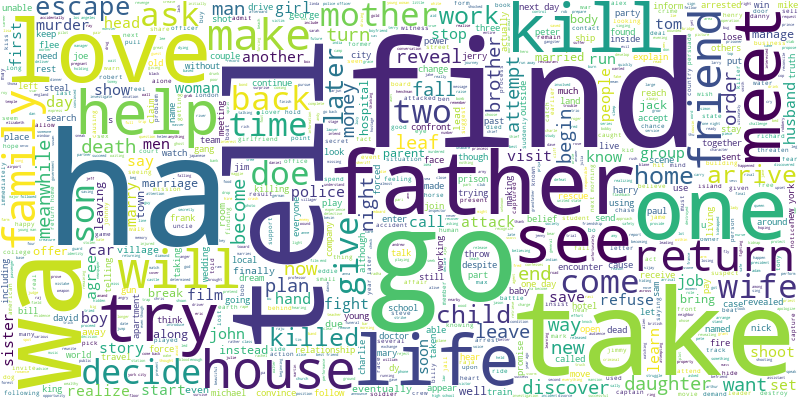

In [8]:
from wordcloud import WordCloud

all_texts = ','.join(list(data.values))
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, 
                      contour_color='steelblue', width=800, height=400)

wordcloud.generate(all_texts)
wordcloud.to_image()

Теперь создадим bag of words. При его создании мы не будем добавлять в словарь стоп-слова -- служебные части речи, которые присутствуют в подавляющем большинстве текстов, и потому не несут значимой информативной нагрузки

In [8]:
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('english') + ['ha', 'wa'])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


В стоп-слова добавлены 'ha' и 'wa' потому что в них лемматизатор превращает слова has и was

Воспользуемся [BOW из sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). Слова, которые встречаются слишком редко (в небольшом числе документов) мы тоже отбросим, чтобы не перегружать словарь

In [9]:
from sklearn.feature_extraction.text import CountVectorizer

In [10]:
count_vectorizer = CountVectorizer(stop_words=stop_words, min_df=10)
count_data = count_vectorizer.fit_transform(data.values)

In [14]:
count_data

<34886x24745 sparse matrix of type '<class 'numpy.int64'>'
	with 4609549 stored elements in Compressed Sparse Row format>

Посмотрим на распределение слов в нашем корпусе текстов

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

def plot_most_common_words(count_data, count_vectorizer, n_words):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:n_words]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='Most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90, fontsize=15) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


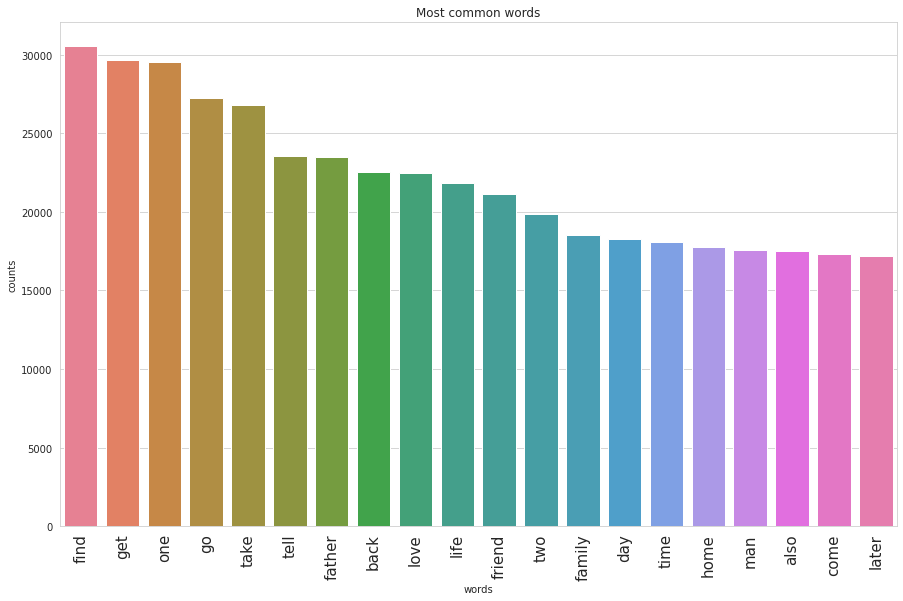

In [75]:
plot_most_common_words(count_data, count_vectorizer, 20)

## Стандартная модель LDA

Теперь приступим к обучению модели. Для начала обучим стандартную модель LDA.

**Задание 1**

Изучите [модель LDA из sklearn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html) и обучите её на подготовленных данных. Посмотрите на распределения слов в темах, выведите наиболее вероятные слова для каждой темы

Вспомагательная функция для визуализации самых вероятных слов в темах:

In [19]:
data

0        a bartender is working at a saloon serving dri...
1        the moon painted with a smiling face hang over...
2        the film just over a minute long is composed o...
3        lasting just second and consisting of two shot...
4        the earliest known adaptation of the classic f...
                               ...                        
34881    the film begin in just after world war i ha en...
34882    two musician salih and gürkan described the ad...
34883    zafer a sailor living with his mother döndü in...
34884    the film centre around a young woman named amy...
34885    the writer orhan şahin return to after so many...
Name: Plot, Length: 34886, dtype: object

In [18]:
count_data

<34886x24745 sparse matrix of type '<class 'numpy.int64'>'
	with 4609549 stored elements in Compressed Sparse Row format>

In [12]:
def print_topics(count_vectorizer, phi_matrix, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(phi_matrix):
        print("\nTopic #{}".format(topic_idx))
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))

In [ ]:
### YOUR CODE HERE

In [13]:
from sklearn.decomposition import LatentDirichletAllocation

In [20]:
lda = LatentDirichletAllocation()
probs = lda.fit_transform(count_data)

In [21]:
print_topics(count_vectorizer, phi_matrix=lda.components_, n_top_words=10)


Topic #0
king harry find one kill take return back prince father

Topic #1
tom jerry war men back captain ship take german one

Topic #2
find one group team escape kill back human attack world

Topic #3
get new school go friend take jack one back home

Topic #4
tell go mother father love home joe mary find see

Topic #5
love get friend go tell find day father one meet

Topic #6
police kill gang murder killed officer one crime prison escape

Topic #7
find car house police go tell kill back michael get

Topic #8
love father family get life son village come daughter mother

Topic #9
film life one new woman billy story friend time jane


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Как видно есть темы, которые очень сильно связаны между собой (4,5,8; 0,2,6,7). Возможно стоило произвести кластеризацию на меньшее количество тем

**Задание 2** 

Часто бывает так, что в LDA выделяется одна или несколько тем с общей лексикой -- т.е. со словами, которые часто встречаются в большом количестве документов корпуса. Проанализируйте полученные в LDA темы и найдите в выделенных темах те, в которые собрались слова общей лексики (или покажите, что таких тем нет). Для этого можно, например:
* проанализировать встречаемость каждой темы в документах, посмотреть на среднее/дисперсию/распределение вероятностей каждой темы в корпусе документов
* посмотреть на встречаемость самых частых слов корпуса в темах

In [ ]:
### YOUR CODE HERE

Как уже видно из предыдущего пункта есть темы с общей лексикой. Например "father" в 4 и 8, "kill" в 0,2,6 и 7 и т.д.


Для начала соотнесём каждому тексту наиболее вероятную тему и посмотрим на распределение тем по текстам

In [22]:
labels = probs.argmax(axis=1)
topic, count = np.unique(labels, return_counts=True)
topic, count 

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([2473, 2941, 2774, 6414, 2668, 2268, 2530, 3324, 5800, 3694]))

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


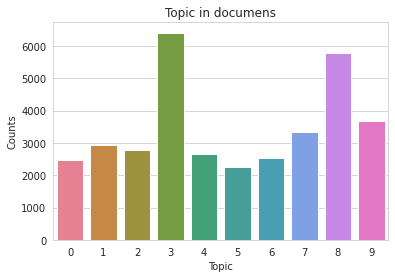

In [23]:
sns.barplot(topic, count, palette='husl')
plt.title('Topic in documens')
plt.xlabel('Topic')
plt.ylabel('Counts')
plt.show()

Теперь посмотрим на средние вероятности появления каждой темы в документах

In [24]:
probs.mean(axis=0), probs.std(axis=0)

(array([0.07404431, 0.08543073, 0.08425103, 0.16002179, 0.08636667,
        0.06525892, 0.09113941, 0.09482902, 0.14720484, 0.11145329]),
 array([0.16985753, 0.17675106, 0.18315211, 0.24153941, 0.16154255,
        0.17352148, 0.15947988, 0.17838367, 0.279609  , 0.19106034]))

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


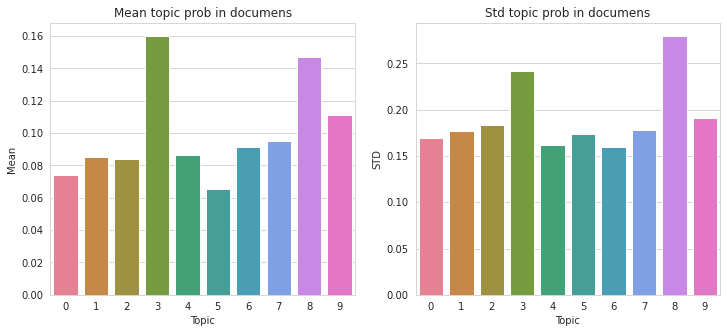

In [25]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.barplot(topic, probs.mean(axis=0), palette='husl')
plt.title('Mean topic prob in documens')
plt.xlabel('Topic')
plt.ylabel('Mean')

plt.subplot(1, 2, 2) 
sns.barplot(topic, probs.std(axis=0), palette='husl')
plt.title('Std topic prob in documens')
plt.xlabel('Topic')
plt.ylabel('STD')
plt.show()

Теперь посмотрим на встречаемость самых частых слов корпуса в темах

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


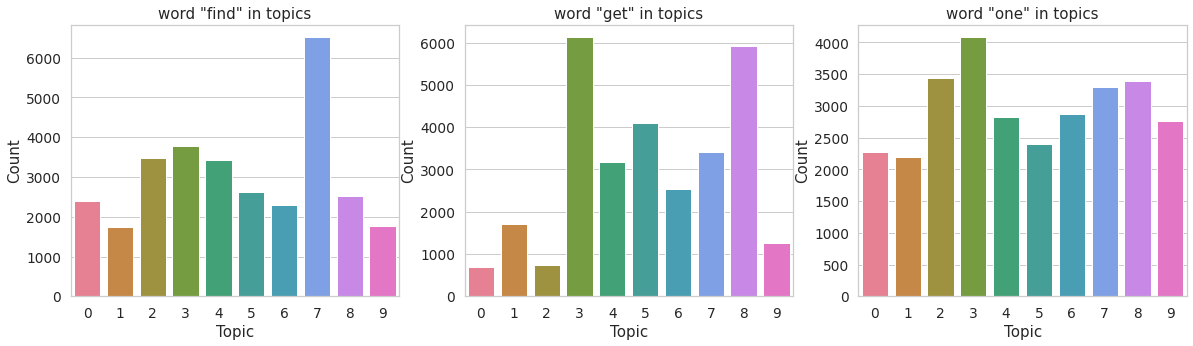

In [89]:
plt.figure(figsize=(20, 5))

plt.subplot(1, 3, 1)
sns.barplot(topic, lda.components_[:, words.index('find')], palette='husl')
plt.title('word "find" in topics')
plt.xlabel('Topic')
plt.ylabel('Count')

plt.subplot(1, 3, 2) 
sns.barplot(topic, lda.components_[:, words.index('get')], palette='husl')
plt.title('word "get" in topics')
plt.xlabel('Topic')
plt.ylabel('Count')

plt.subplot(1, 3, 3) 
sns.barplot(topic, lda.components_[:, words.index('one')], palette='husl')
plt.title('word "one" in topics')
plt.xlabel('Topic')
plt.ylabel('Count')

plt.show()

Как видно есть темы, в которых одни и те же слова встречаются одинаковое количество раз

## Упрощенная модель LDA (у каждого документа только одна тема)

Теперь обучим упрощенную модель LDA, разобранную на семинаре. В данной модели одному документу соответсвует одна тема. Вероятностная модель выглядит следующим образом:

Случайные величины:
* $w_{dn}$ -- слово, стоящее на $n$-ой позиции в документе $d$ (наблюдаемая случайная величина)
* $t_d$ -- тема документа $d$ (латентная случайная величина)

Параметры модели:
* $\Phi = \{\phi_{tw}\} \in \mathbb{R}^{T\times V}$ -- матрица распределений слов по темам  ($T$ -- число тем, $V$ -- размер словаря)
* $\pi \in \mathbb{R}^T$ -- вектор распределения тем в корпусе документов 

Совместное распределение на слова в документах и темы документов задается следующим образом:

$p(W, t \;|\; \Phi, \pi) = p(W \;|\; t, \Phi) p(t \;|\; \pi) = \prod_{d=1}^D \prod_{n=1}^{N_d}p(w_{dn}\;|\;t_d, \Phi) p(t_d \;|\; \pi) = \prod_{d=1}^D \prod_{n=1}^{N_d} \phi_{t_d w_{dn}}\pi_{t_d}$

Поскольку в модели присутствуют латентные переменные, оптимизацию параметров мы будем вести с помощью ЕМ-алгоритма:
* **E-шаг:**  $KL(q(t) \;||\; p(t\;|\;\Phi, \pi) ) \to \min_{q(t)}$
* **M-шаг:** $\mathbb{E}_{q(t)} \log p(W, t \;|\; \Phi, \pi) \to \max_{\Phi, \pi}$

**Задание 3**

Выведите формулы для нахождения $q(t_d = t) = \mu_{dt},\;\Phi,\;\pi$ и оптимизируемого функционала ELBO

In [ ]:
### YOUR FORMULAS HERE

$$
ELBO = \mathbb{E}_{q(t)} \log p(W, t \;|\; \Phi, \pi) - \mathbb{E}_{q(t)} \log q(t) = \sum_d \sum_t \mu_{dt} (\log \pi_t + \sum_n \log \phi_{t, w_{dn}})- \sum_d \sum_t \mu_{dt} \log \mu_{dt}
$$

Остальные формулы были выведены и получены семинаре. Отправляю их в отдельном пдф файле. 


P.s. Очень сильно хотел их тут затехать, но к сожалению Португалия с Англией не дали мне этой возможности.

**Задание 4**

Реализуйте упрощенный LDA

**Подсказка:** Если вам нужно будет посчитать $\log Softmax$, лучше воспользуйтесь устойчивым способом подсчета из второй практической работы:

$$\alpha_i = \log{p_i(\dots)} \quad\rightarrow \quad
	\frac{e^{\alpha_i}}{\sum_k e^{\alpha_k}} = 
	\frac{e^{(\alpha_i - \max_j \alpha_j)}}{\sum_k e^{(\alpha_k- \max_j \alpha_j)}}$$

In [14]:
from scipy.special import softmax

In [29]:
class SimpleLDA(object):
    def __init__(self, n_topics, epsilon=1e-15, tol=1e-5):
        self.n_topics = n_topics
        self.epsilon = epsilon
        self.tol = tol
        
    def fit(self, bow, verbose=True):
        self._initialize(bow)
        elbo = -np.inf
        for it in range(1000):
            self._e_step(bow)
            self._m_step(bow)
            new_elbo = self._count_elbo(bow)
            diff = new_elbo - elbo
            if verbose:
                print("\n{}:\n elbo: {}\n increase: {}".format(it, new_elbo, diff))
            if diff < self.tol:
                break
            elbo = new_elbo
            
    
    def _initialize(self, bow):
        V = bow.shape[1]
        self.mu = None
        self.pi = np.abs(np.random.randn(self.n_topics))
        self.pi = self.pi / self.pi.sum()
        self.phi = np.abs(np.random.randn(self.n_topics, V))
        self.phi = self.phi / self.phi.sum(axis=1)[:, np.newaxis]
        
    def _e_step(self, bow):
        ### YOUR CODE HERE ###
        alpha = (np.log(self.pi[:, np.newaxis] + 1e-10) + np.log(self.phi + 1e-10) @ bow.T).T # D*T
        max = alpha.max(axis = 1)
        self.mu = softmax(alpha - max[:, np.newaxis], axis=1)

        
    def _m_step(self, bow):
        ### YOUR CODE HERE ###
        self.pi = self.mu.mean(axis=0)
        nd = np.array(bow.sum(axis=1))
        self.phi = self.mu.T @ bow / (self.mu*nd).sum(axis=0)[:, np.newaxis]

    
    def _count_elbo(self, bow):
        ### YOUR CODE HERE ###
        mean_q = (self.mu*np.log(self.mu + 1e-10)).sum()
        mean_p = (self.mu.T * (np.log(self.pi[:, np.newaxis] + 1e-10) + np.log(self.phi + 1e-10) @ bow.T)).sum()
        elbo = mean_p - mean_q
        return elbo

**Задание 5**

Обучите упрощенный LDA и посмотрите на самые вероятные слова в каждой теме. Насколько различные получились темы? Насколько интерпретируемые? Сравните их с темами, полученными в классической модели LDA. 

In [41]:
### YOUR CODE HERE ###

In [19]:
lda_my.mu.sum(axis=1)

array([1., 1., 1., ..., 1., 1., 1.])

In [30]:
lda_my = SimpleLDA(n_topics=10)
lda_my.fit(count_data)


0:
 elbo: -56080404.8354678
 increase: inf

1:
 elbo: -55897637.21587657
 increase: 182767.61959122866

2:
 elbo: -55605846.05294276
 increase: 291791.16293381155

3:
 elbo: -55312918.455649875
 increase: 292927.5972928852

4:
 elbo: -55223282.51535413
 increase: 89635.94029574841

5:
 elbo: -55171131.07620748
 increase: 52151.43914664537

6:
 elbo: -55130730.14120224
 increase: 40400.93500524014

7:
 elbo: -55101128.705278605
 increase: 29601.43592363596

8:
 elbo: -55077781.29524718
 increase: 23347.410031422973

9:
 elbo: -55060547.4146893
 increase: 17233.880557879806

10:
 elbo: -55047413.62171312
 increase: 13133.79297618568

11:
 elbo: -55036139.44379514
 increase: 11274.177917979658

12:
 elbo: -55026986.24846361
 increase: 9153.195331528783

13:
 elbo: -55018987.81393945
 increase: 7998.434524156153

14:
 elbo: -55013001.57151659
 increase: 5986.242422863841

15:
 elbo: -55007130.9325334
 increase: 5870.63898319006

16:
 elbo: -55001598.40848297
 increase: 5532.524050429463



In [31]:
print_topics(count_vectorizer, phi_matrix=lda_my.phi, n_top_words=10)


Topic #0
tom go tell get find take back jerry one home

Topic #1
one find take two tell back go love get return

Topic #2
find one tell take go back love get home return

Topic #3
one find take war two men back kill return escape

Topic #4
find one kill go house back take tell two home

Topic #5
find one back take go two tell kill get return

Topic #6
love get father life family one come friend go take

Topic #7
police get find take one go man back money kill

Topic #8
find one police take go tell get two man kill

Topic #9
go one get life find father friend new tell take


/usr/local/lib/python3.8/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Темы получились плюс минус интерпретируемы и примерно такие же как и в классической реализации. Можно выделить темы про семью, любовь, убийство, полицию, школу. В данной реализации намного сильнее просматривается факт того, что разные темы имеют общую лексику. Практически везде встречаются слова "find", "one", "get" и т.д.


**Задание 6**

У упрощенной модели LDA могли возникнуть проблемы из-за слов общей лексики. Попробуйте отбросить из словаря слова, которые встречаются больше, чем в 10% документов и обучить упрощенный LDA на этих данных. Посмотрите на получившиеся темы. Как они отличаются от тем модели, обученной на словаре с общей лексикой? Чем объясняются эти различия? Почему у стандартной модели LDA возникает меньше проблем со словами общей лексики?

In [ ]:
### YOUR CODE HERE ###

In [32]:
count_vectorizer_new = CountVectorizer(stop_words=stop_words, min_df=10, max_df=0.1)
count_data_new = count_vectorizer_new.fit_transform(data.values)

In [33]:
count_data

<34886x24745 sparse matrix of type '<class 'numpy.int64'>'
	with 4609549 stored elements in Compressed Sparse Row format>

In [34]:
count_data_new

<34886x24569 sparse matrix of type '<class 'numpy.int64'>'
	with 3477723 stored elements in Compressed Sparse Row format>

In [37]:
lda_my = SimpleLDA(n_topics=10)
lda_my.fit(count_data_new)


0:
 elbo: -43548447.19599629
 increase: inf

1:
 elbo: -43412942.96012424
 increase: 135504.2358720526

2:
 elbo: -43336433.049937084
 increase: 76509.91018715501

3:
 elbo: -43238774.24161831
 increase: 97658.80831877142

4:
 elbo: -43064784.421564646
 increase: 173989.82005366683

5:
 elbo: -42879541.51594418
 increase: 185242.9056204632

6:
 elbo: -42777996.42425011
 increase: 101545.09169407189

7:
 elbo: -42725881.742984116
 increase: 52114.68126599491

8:
 elbo: -42689526.51987934
 increase: 36355.22310477495

9:
 elbo: -42666023.49623043
 increase: 23503.023648910224

10:
 elbo: -42649740.13423306
 increase: 16283.361997373402

11:
 elbo: -42636840.72724846
 increase: 12899.406984597445

12:
 elbo: -42627336.74468645
 increase: 9503.98256201297

13:
 elbo: -42618969.452148445
 increase: 8367.292538002133

14:
 elbo: -42612602.255793005
 increase: 6367.1963554397225

15:
 elbo: -42607183.09301433
 increase: 5419.162778675556

16:
 elbo: -42602170.37406253
 increase: 5012.7189517

In [38]:
print_topics(count_vectorizer, phi_matrix=lda_my.phi, n_top_words=10)


Topic #0
shape dy alicia hotline credit iou ponnambalam tahiti filly cao

Topic #1
visitation generate amends armory smashed jessie briggs cao kessler shape

Topic #2
vegetarian quinlan ramos vasudevan quincy colette rajkiran morell knowing shue

Topic #3
tahiti gag future laurie kishen mcpherson holding whoopi welcomed marital

Topic #4
agent bolt jeffries tahiti foshan visitation mendez alessandro irrationally gatecrash

Topic #5
buckley sabbath hard pennant kessler foshan heel newfound arshad elevator

Topic #6
thrashing jaya jessie radha bikers cassandra tahiti stooge dj ankur

Topic #7
jessie mendez darrow parkinson mascot honourable dj dominick thrashing gruesome

Topic #8
hard thrashing gag rickey martine honourable gruesome drifter alibi prehistoric

Topic #9
irrationally jeremy neetu work jessie apache bigot gel parkinson characteristic


После того как убрали частовстречаемые слова, темы стали описываться более конкретными словами. Хотя темы несколько изменились. У стандартной реализации возникает меньше проблем, так как она предполагает, что в тексте может встречаться несколько тем. Таким образом, темы с общей лексикой могут в равной степени присутствовать в документе. К тому же там есть априорное значение за тематический профиль текста, который сильно ограничивает возможное количество тем.